# Backend Verification for the iHP Open MPW Shuttles

[D. Mitch Bailey](https://www.linkedin.com/in/mitch-bailey-cvc/), [ShuhariSystem](https://www.shuharisystem.com/)

# Overview
This notebook performs backend LVS (with [klayout](https://github.com/KLayout/klayout) or [magic](https://github.com/RTimothyEdwards/magic)/[netgen](https://github.com/RTimothyEdwards/netgen)), soft-connection checks (with magic/netgen) and/or reliability verfication (with [CVC-RV](https://github.com/d-m-bailey/cvc)) with open source EDA software and systems.

# iHP Open-MPW Data
The 17 submissions to iHp open mpw shuttle for April 2025 listed below are located [here](https://github.com/IHP-GmbH/TO_Apr2025).

* 160GHz_LNA
* 40_GHZ_LOW_NOISE_TIA
* 6502-cpu
* 97_GHZ_LINEAR_TIA
* DC_to_130_GHz_TIA
* GPS_LNA
* Greyhound
* Mixer5GHz
* PA_180GHz
* TTIHP0p2
* TTIHP25a
* VCO_130nm_LSI
* active_L_VCOs
* ascon
* bandgap_ref_cmos
* elemrv-n
* i2c-gpio-expander

Create a file with the initial environment variables.


In [1]:
%%writefile /content/env
export LOCAL_INSTALL=/content/local
export PATH=$PATH:$LOCAL_INSTALL/bin
export PDK_ROOT=/content/pdks
export PDK=ihp-sg13g2
export PDKPATH=$PDK_ROOT/$PDK
export PDK_COMMIT=ddb601a4a4473163e1ed6df416b885df18b4ac03
export MAGIC_COMMIT=master
export NETGEN_COMMIT=master
export KLAYOUT_DISTRO=Ubuntu-22
export KLAYOUT_DEB=klayout_0.30.1-1_amd64.deb
export EXTRA_CHECK_COMMIT=ihp-sg13g2
export CVC_COMMIT=master
export DATA_ROOT=/content/data
export CHECK_ROOT=/content/check_data
export LVS_ROOT=/root/extra_be_checks
export MPW=TO_Apr2025
if [[ -f $DATA_ROOT/project_env ]]; then
  cat $DATA_ROOT/project_env
  source $DATA_ROOT/project_env
fi


Writing /content/env


# Program installation.
Only needs to be executed once.

This step sets up the pdk and installs magic, klayout, netgen and cvc_rv.

Runtime: 3-4 minutes.

In [2]:
%%shell
cd
cat /content/env
source /content/env

lsb_release -a 2>/dev/null

if [[ ! -d $PDK_ROOT ]]; then
  echo "==> Installing ciel..."
  pip install ciel
fi
ciel enable --pdk $PDK $PDK_COMMIT
# patch for mimcap and antenna error in netgen setup file from pdk
sed -i.bak '/lsearch .cells2/,/circuit2/s/circuit1 .dev/circuit2 $dev/' $PDK_ROOT/$PDK/libs.tech/netgen/ihp-sg13g2_setup.tcl

# allow met7 text to be recognized on pads
sed -i.bak -e '/labels PADID/a\
labels MET7PIN port\
labels MET7TXT text
' \
  -e '/pad/!s/\*m7,m7fill,pillar,solder/&,pad/g' $PDK_ROOT/$PDK/libs.tech/magic/ihp-sg13g2.tech

# ignore rule that creates separate taps for labeled wells
# ignore gaurdring when computing ptap_holes
sed -i.bak -e '/^well_patt/s/"/"-/' -e '/^sub_patt/s/"/"-/' \
  -e 's/ptap_holes = .*/ptap_holes = ptap.not(edgeseal_drw).holes/' $PDK_ROOT/$PDK/libs.tech/klayout/tech/lvs/rule_decks/general_derivations.lvs

# fix rfmim_sub
sed -i.bak -e 's/rfmim_sub =.*/rfmim_sub = rfmim_area.sized(1.um)/' $PDK_ROOT/$PDK/libs.tech/klayout/tech/lvs/rule_decks/cap_derivations.lvs

# fix cap reduction
mv $PDK_ROOT/$PDK/libs.tech/klayout/tech/lvs/rule_decks/custom_mim_extractor.lvs $PDK_ROOT/$PDK/libs.tech/klayout/tech/lvs/rule_decks/custom_mim_extractor.lvs.org
awk '\
/Adding extra param.*rfcmim/ { print "    self.combiner = MIMCAPNDeviceCombiner.new"; } \
/if name.downcase.include...rfcmim/ { comment += 1; } \
comment == 1 { $1 = "#" $1; } \
comment == 1 && $1 == "#end" { comment += 1; } \
 { print $0; }' \
  $PDK_ROOT/$PDK/libs.tech/klayout/tech/lvs/rule_decks/custom_mim_extractor.lvs.org > \
  $PDK_ROOT/$PDK/libs.tech/klayout/tech/lvs/rule_decks/custom_mim_extractor.lvs

echo "==> Using pdk $PDK commit $PDK_COMMIT (patched)
"

if [[ ! -d extra_be_checks ]]; then
  echo "==> Downloading extra_be_checks $EXTRA_CHECK_COMMIT"
  rm -rf extra_be_checks
  git clone https://github.com/d-m-bailey/extra_be_checks.git -b $EXTRA_CHECK_COMMIT
  mv $PDK_ROOT/$PDK/libs.tech/magic/ihp-sg13g2.tech $PDK_ROOT/$PDK/libs.tech/magic/ihp-sg13g2.tech.org
  cp extra_be_checks/tech/ihp-sg13g2/ihp-sg13g2.tech $PDK_ROOT/$PDK/libs.tech/magic/ihp-sg13g2.tech
  # Exchange npn13g2 l/w params
  sed -i.bak -e 's/w1=we l1=le/w1=le l1=we/' $PDK_ROOT/$PDK/libs.tech/magic/ihp-sg13g2.tech
fi
echo "==> Using extra_be_checks commit $(cd extra_be_checks; git rev-parse HEAD)
"

if ! command -v netgen; then
  echo "==> Downloading and installing netgen $NETGEN_COMMIT"
  git clone https://github.com/RTimothyEdwards/netgen.git --depth=1 -b $NETGEN_COMMIT
  cd netgen
  ./configure --prefix=$LOCAL_INSTALL
  make
  make install
  cd
fi
echo "==> Using netgen version $(netgen -batch | awk '/Netgen/ {print $2}')
"

if ! command -v magic; then
  echo "==> Downloading and installing magic $MAGIC_COMMIT"
  git clone https://github.com/RTimothyEdwards/magic.git --depth=1 -b $MAGIC_COMMIT
  cd magic
  ./configure --prefix=$LOCAL_INSTALL
  make
  make install
  cd
fi
echo "==> Using magic version $(magic -dnull -noc --version)
"

if ! command -v klayout; then
  echo "==> Downloading and installing klayout $KLAYOUT_DEB for $KLAYOUT_DISTRO"
  wget -P /root https://www.klayout.org/downloads/$KLAYOUT_DISTRO/$KLAYOUT_DEB
  sudo apt install /root/$KLAYOUT_DEB
  pip install docopt
  pip install klayout
  cd
fi
echo "==> Using $(klayout -v)
"

if ! command -v cvc_rv; then
  echo "==> Downloading and installing cvc_rv $CVC_COMMIT"
  sudo apt install autopoint bison flex
  git clone https://github.com/d-m-bailey/cvc --depth=1 -b $CVC_COMMIT
  cd cvc
  autoreconf -vif
  ./configure --prefix=$LOCAL_INSTALL --disable-nls
  make
  make install
  cd
fi
echo "==> Using $(cvc_rv -v)
"

export LOCAL_INSTALL=/content/local
export PATH=$PATH:$LOCAL_INSTALL/bin
export PDK_ROOT=/content/pdks
export PDK=ihp-sg13g2
export PDKPATH=$PDK_ROOT/$PDK
export PDK_COMMIT=ddb601a4a4473163e1ed6df416b885df18b4ac03
export MAGIC_COMMIT=master
export NETGEN_COMMIT=master
export KLAYOUT_DISTRO=Ubuntu-22
export KLAYOUT_DEB=klayout_0.30.1-1_amd64.deb
export EXTRA_CHECK_COMMIT=ihp-sg13g2
export CVC_COMMIT=master
export DATA_ROOT=/content/data
export CHECK_ROOT=/content/check_data
export LVS_ROOT=/root/extra_be_checks
export MPW=TO_Apr2025
if [[ -f $DATA_ROOT/project_env ]]; then
  cat $DATA_ROOT/project_env
  source $DATA_ROOT/project_env
fi
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy
==> Installing ciel...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 7.8 MB/s eta 0:00:00
Version ddb601a4a4473163e1ed6df416b885df18b4ac03 not found locally, attempting 
to download…
⠋ Unpacking common.tar.zst…
⠙ Unpacking sg13g2_io.tar.zst…
⠋ Unpacking sg13g2

# Clone the design repo and list the gds, spice and verilog files.

Run to refresh the design data.
The file list is also saved in /content/filelist.txt.

Runtime: 1-2 minutes.

In [3]:
%%shell
cat /content/env
source /content/env
rm -rf $DATA_ROOT $CHECK_ROOT
git clone https://github.com/d-m-bailey/ihp-mpw-be.git --depth=1 -b TO_Apr2025 $CHECK_ROOT
git clone https://github.com/IHP-GmbH/$MPW.git --depth=1 $DATA_ROOT
cd data
# uncompress gds, spice, cdl, and verilog files
find . \( -name "*.gds.gz" -o -name "*.spice.gz" -o -name "*.cdl.gz" -o -name "*.v.gz" \) -execdir gunzip -v {} \;
find . \( -name "*.gds.zip" -o -name "*.spice.zip" -o -name "*.cdl.zip" -o -name "*.v.zip" \) -execdir 7z x {} \;
# Create a file listing the size, project and relevant file names.
# Only list files that end with .gds (in gds subdirectories), .spice, .cdl, or .v.
tee /content/filelist.txt <<EOF
   Size Project                   File
------- ------------------------- ---------------------------------------------
EOF
ls -s $(find . \( -name "*.gds" -path "*/gds/*" \) -o -name "*.spice" -o -name "*.cdl" -o -name "*.v") |
  sed -e 's,\./,,' -e 's,/, ,' |
  awk '{printf "%7d %-25s %s\n", $1, $2, $3}' |
  tee -a /content/filelist.txt

export LOCAL_INSTALL=/content/local
export PATH=$PATH:$LOCAL_INSTALL/bin
export PDK_ROOT=/content/pdks
export PDK=ihp-sg13g2
export PDKPATH=$PDK_ROOT/$PDK
export PDK_COMMIT=ddb601a4a4473163e1ed6df416b885df18b4ac03
export MAGIC_COMMIT=master
export NETGEN_COMMIT=master
export KLAYOUT_DISTRO=Ubuntu-22
export KLAYOUT_DEB=klayout_0.30.1-1_amd64.deb
export EXTRA_CHECK_COMMIT=ihp-sg13g2
export CVC_COMMIT=master
export DATA_ROOT=/content/data
export CHECK_ROOT=/content/check_data
export LVS_ROOT=/root/extra_be_checks
export MPW=TO_Apr2025
if [[ -f $DATA_ROOT/project_env ]]; then
  cat $DATA_ROOT/project_env
  source $DATA_ROOT/project_env
fi
Cloning into '/content/check_data'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 19 (delta 1), reused 14 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 137.34 KiB | 3.92 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Cloning into 

# ※ Run cells before this cell for program installation and general setup.<br>Then choose one setup from the 17 designs below.<br>Finally, run the checks and examine the results.

# 1. 160GHz_LNA

Checks will not work with GDS file in repo.
1. Copy text from `LNA` ports to top level layout.
2. Add dfpad.drawing - 41/0 along with TopMetal2.drawing on RF_INPUT/OUTPUT pins
3. Save as `FMD_QNC_04_160GHz_LNA.mod.gds` and upload to `/content/data/160GHz_LNA/design_data/gds`.

Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $DATA_ROOT/project_env <<'EOF'
export PROJECT=160GHz_LNA
export LAYOUT_TOP=FMD_QNC_04_160GHz_LNA
export GDSFILE=design_data/gds/FMD_QNC_04_160GHz_LNA.mod.gds
export WORK_ROOT=$DATA_ROOT/$PROJECT/work/$PROJECT
export SPICE_FILE=$CHECK_ROOT/$MPW/$PROJECT/xschem/lvs/$PROJECT.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $DATA_ROOT/project_env
source $DATA_ROOT/project_env
rm -f $DATA_ROOT/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT $DATA_ROOT/work
ls -l $DATA_ROOT/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $PROJECT GND VBB1 VBB2 VCC RF_INPUT RF_OUTPUT

* XQ1 net2 net1 float1 GND npn13g2 AE=0.063p PE=1.94u AB=25.605p PB=23.02u
Q1 net2 net1 GND GND npn13g2 AE=0.063p PE=1.94u AB=25.605p PB=23.02u
+ AC=25.589984p PC=23.01u NE=4 m=4
* XQ2 net4 net3 float2 GND npn13g2 AE=0.063p PE=1.94u AB=25.605p PB=23.02u
Q2 net4 net3 GND GND npn13g2 AE=0.063p PE=1.94u AB=25.605p PB=23.02u
+ AC=25.589984p PC=23.01u NE=4 m=4
* XQ3 net6 net5 float3 GND npn13g2 AE=0.063p PE=1.94u AB=12.988p PB=15.62u
Q3 net6 net5 GND GND npn13g2 AE=0.063p PE=1.94u AB=12.988p PB=15.62u
+ AC=12.976684p PC=15.61u NE=2 m=2
* XQ4 net8 net7 float4 GND npn13g2 AE=0.063p PE=1.94u AB=12.988p PB=15.62u
Q4 net8 net7 GND GND npn13g2 AE=0.063p PE=1.94u AB=12.988p PB=15.62u
+ AC=12.976684p PC=15.61u NE=2 m=2

RC1 net2 VCC rsil w=7.5u l=5u ps=0 b=0 m=1
RC2 net4 VCC rsil w=7.5u l=5u ps=0 b=0 m=1
RC3 net6 VCC rsil w=7.5u l=5u ps=0 b=0 m=1
RC4 net8 VCC rsil w=7.5u l=5.5u ps=0 b=0 m=1

RB1 net1 VBB1 rhigh w=1.9u l=6u ps=0 b=0 m=1
RB2 net3 VBB1 rhigh w=1.9u l=5u ps=0 b=0 m=1
RB3 net5 VBB1 rhigh w=1.9u l=6u ps=0 b=0 m=1
RB4 net7 VBB2 rhigh w=2u l=6u ps=0 b=0 m=1

* RM1 net_2_3 GND res_topmetal2 w=15u l=1u
* RM2 net_4_5 GND res_topmetal2 w=15u l=1u
* RM3 net_6_7 GND res_topmetal2 w=15u l=1u
* RM4 net_8_O GND res_topmetal2 w=15u l=1u

CC1 VCC GND cap_cmim w=20u l=25u A=500p P=90u m=8
CB1 VBB1 GND cap_cmim w=20u l=25u A=500p P=90u m=6
CB2 VBB2 GND cap_cmim w=20u l=25u A=500p P=90u m=4

XCRC1 RF_INPUT net1 GND rfcmim w=10u l=15u wfeed=6u
* XCRC2 net2 net2_3 GND cap_rfcmim w=32u l=3.72u wfeed=3u
XCRC2 net2 GND GND rfcmim w=32u l=3.72u wfeed=3u
* XCRC3 net2_3 net3 GND cap_rfcmim w=5.2u l=2.4u wfeed=3u
XCRC3 GND net3 GND rfcmim w=5.2u l=2.4u wfeed=3u
* XCRC4 net4 net4_5 GND cap_rfcmim w=32u l=3.72u wfeed=3u
XCRC4 net4 GND GND rfcmim w=32u l=3.72u wfeed=3u
* XCRC5 net4_5 net5 GND cap_rfcmim w=7.6u l=2.5u wfeed=3u
XCRC5 GND net5 GND rfcmim w=7.6u l=2.5u wfeed=3u
* XCRC6 net6 net6_7 GND cap_rfcmim w=32u l=12.5u wfeed=3u
XCRC6 net6 GND GND rfcmim w=32u l=12.5u wfeed=3u
* XCRC7 net6_7 net7 GND cap_rfcmim w=5.1u l=2.4u wfeed=3u
XCRC7 GND net7 GND rfcmim w=5.1u l=2.4u wfeed=3u
* XCRC8 net8 net8_O GND cap_rfcmim w=32u l=6.2u wfeed=3u
XCRC8 net8 GND GND rfcmim w=32u l=6.2u wfeed=3u
* XCRC9 net8_O RF_OUTPUT GND cap_rfcmim w=3.2u l=2.4u wfeed=3u
XCRC9 GND RF_OUTPUT GND rfcmim w=3.2u l=2.4u wfeed=3u

.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$PROJECT",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "npn13G2*",
    "cmim*",
    "rfcmim*",
    "rsil*",
    "via_stack*",
    "GND",
    "sealring*",
    "*_stage",
    "LNA",
    "rhigh*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$DATA_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
GND power 0.0
VCC power 3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[QMRCD]/s/.//' \
    -e "s/\.subckt $PROJECT/.subckt $LAYOUT_TOP/I" $SPICE_FILE > $KLAYOUT_CDL


Results for 160GHz_LNA
*   layout has cells that have the same name as primitive devices. This causes netgen to segfault. <br>=> Flatglob all layout cells with primitive device names.
* Top layout does not have text. LNA level has text, but also has missing connectivity. <br>=> Copy text from LNA ports to top level.
* Top level met7 text on pads is not recognized in magic extraction. For magic, change tech file or switch to PADID. However, PADID not used in klayout.
* `RF_OUTPUT` and `RF_INPUT` pads are missing `dfpad_drw` layer.<br>Add rectangular `dfpad_drw` shapes.

# 2. 40_GHZ_LOW_NOISE_TIA


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=40_GHZ_LOW_NOISE_TIA
export LAYOUT_TOP=FDM_QNC_00_LN_TIA
export GDSFILE=design_data/gds/FMD_QNC_00_40_GHz_Low_Noise_TIA.mod.gds
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP GND VCC1 VCC2 VCC3 RFin RFout

XCc1 VCC1 GND cap_cmim w=30u l=60u A=1800p P=180u m=2
XCc2 VCC2 GND cap_cmim w=30u l=60u A=1800p P=180u m=2
XCc3 VCC3 GND cap_cmim w=30u l=60u A=1800p P=180u m=2

XRRF RFin net2 rppd w=2u l=6.5u ps=0 b=0 m=1

XRRC1 VCC1 net1 rppd w=8u l=4.5u ps=0 b=0 m=1
XRRE2 net2 GND rppd w=3u l=6u ps=0 b=0 m=1

XRRC3 VCC3 RFout rsil w=4u l=14.5u ps=0 b=0 m=1
XRRE3 net3 GND rsil w=4u l=3u ps=0 b=0 m=1

*~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
* For properly connected emitter
*~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
XQq1 net1 RFin GND GND npn13G2 AE=0.063p PE=1.94u AB=63.456p PB=45.22u
+ AC=63.429884p PC=45.21u NE=10 m=10
XQq2 VCC2 net1 net2 GND npn13G2 AE=0.063p PE=1.94u AB=31.9135p
+ PB=26.72u AC=31.896634p PC=26.71u NE=5 m=5
XQq3 RFout net2 net3 GND npn13G2 AE=0.063p PE=1.94u AB=63.456p
+ PB=45.22u AC=63.429884p PC=45.21u NE=10 m=10

*~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
* For debugging tech that does not connect emitter
*~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
* XQq1 net1 RFin float1 GND npn13G2 AE=0.063p PE=1.94u AB=63.456p PB=45.22u
* + AC=63.429884p PC=45.21u NE=10 m=10
* XQq2 VCC2 net1 float2 GND npn13G2 AE=0.063p PE=1.94u AB=31.9135p
* + PB=26.72u AC=31.896634p PC=26.71u NE=5 m=5
* XQq3 RFout net2 float3 GND npn13G2 AE=0.063p PE=1.94u AB=63.456p
* + PB=45.22u AC=63.429884p PC=45.21u NE=10 m=10
*~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "cmim*",
    "npn13G2*",
    "rppd*",
    "rsil*",
    "sealring*",
    "VIA_STACK*",
    "DC_PAD_DOWN",
    "DC_PAD_UP",
    "INPUT_PAD",
    "OUTPUT_PAD",
    "*FILL_CELL*",
    "GND_PLANE",
    "*_STAGE",
    "TIA"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
GND power 0.0
VCC* power 3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[MQRC]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for 40_GHZ_LOW_NOISE_TIA
*   layout has cells that have the same name as primitive devices. This causes netgen to segfault. <br>=> Flatglob all layout cells with primitive device names.
* Top layout does not have text. `TIA` level has text, but also has missing connectivity. <br>=> Copy text from `TIA` ports to top level.
*  `VCC3` text does not overlap pin shape.<br>=> move text.
* `VCC1` an `VCC3` connections are reversed.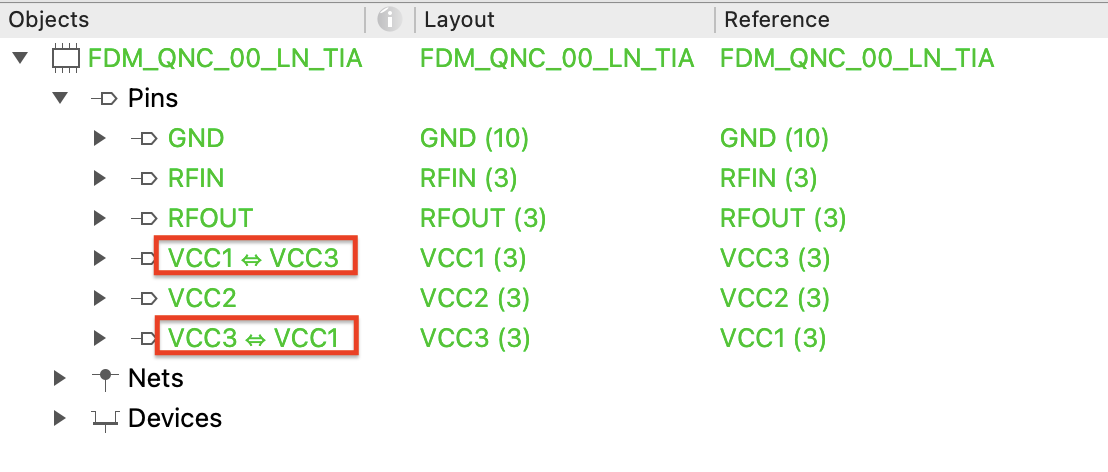
* Top level met7 text on pads is not recognized in magic extraction. For magic, change tech file or switch to PADID. However, PADID is not used in klayout.
* Uses modified `npn13G2` devices. Modifing `npn13G2*` layouts is not allowed because the foundry adds layers.<br>This probably invalidates the design. No further analysis.

# 3. 6502-cpu


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=6502-cpu
export LAYOUT_TOP=cpu_top
export GDSFILE=design_data/gds/FMD_QNC_18_6502-cpu.2.gds
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for 6502-cpu (incomplete)
*   Missing top level power and ground.<br>=> Add top level pins for `iovss`, `iovdd`, `vdd`, and `vss`.
* Missing source netlist.
* `substrate` layer in `io` cells is not extracted as expected in magic.

# 4. 97_GHZ_LINEAR_TIA

Not ready - do not run.

Checks will not work with GDS file in repo.
1. Copy text from `TIA` ports to top level layout.
2. Save as `FMD_QNC_01_97_GHZ_LINEAR_TIA.mod.gds` and upload to `/content/data/97_GHZ_LINEAR_TIA/design_data/gds`.

Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=97_GHZ_LINEAR_TIA
export LAYOUT_TOP=FMD_QNC_01_LIN_TIA
export GDSFILE=design_data/gds/FMD_QNC_01_97_GHZ_LINEAR_TIA.mod.gds
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF

.SUBCKT $LAYOUT_TOP RFIN RFOUT VCC1 VCC2 GND


XCDC3 VCC1 GND cap_cmim w=20u l=100u A=2000p P=240u m=1
XCDC1 VCC1 GND cap_cmim w=60u l=60u A=3600p P=240u m=2
XCDC24 VCC2 GND cap_cmim w=60u l=60u A=3600p P=240u m=2

XRRC1 VCC1 NET12 rppd w=8.5U l=2U m=1
XRRE2 NET23 GND rhigh w=8U l=8.2U m=1
XRRE3 NET34 GND rppd w=4U l=2.9U m=1
XRRC4 VCC2 RFOUT rppd w=20.6U l=2.1U m=1
XQQ11 NET1 RFIN GND GND npn13G2 AE=0.063p PE=1.94u AB=63.456p PB=45.22u
+ AC=63.429884p PC=45.21u NE=10 m=10
XQQ12 NET12 VB1 NET1 GND npn13G2 AE=0.063p PE=1.94u AB=12.988p PB=15.62u
+ AC=12.976684p PC=15.61u NE=2 m=2
XQQ21 VCC2 NET12 NET23 GND npn13G2 AE=0.063p PE=1.94u AB=31.9135p PB=26.72u
+ AC=31.896634p PC=26.71u NE=5 m=5
XQQ31 NET3 NET23 NET34 GND npn13G2 AE=0.063p PE=1.94u AB=31.9135p PB=26.72u
+ AC=31.896634p PC=26.71u NE=5 m=5
XQQ32 VCC1 VCC1 NET3 GND npn13G2 AE=0.063p PE=1.94u AB=12.988p PB=15.62u
+ AC=12.976684p PC=15.61u NE=2 m=2
XQQ41 NET4 NET34 net0 GND npn13G2 AE=0.063p PE=1.94u AB=63.456p PB=45.22u
+ AC=63.429884p PC=45.21u NE=10 m=10

XCCB1 VB1 GND cap_cmim w=30u l=30u A=900p P=120u m=1
XCCB2 VB2 GND cap_cmim w=30u l=30u A=900p P=120u m=1

XQQB11 VB1 net1 net2 GND npn13G2 AE=0.063p PE=1.94u AB=6.6795p PB=11.92u
+ AC=6.670034p PC=11.91u NE=1 m=1
XQQB12 net3 net4 GND GND npn13G2 AE=0.063p PE=1.94u AB=6.6795p PB=11.92u
+ AC=6.670034p PC=11.91u NE=1 m=1
XQQB21 VB2 net5 net6 GND npn13G2 AE=0.063p PE=1.94u AB=6.6795p PB=11.92u
+ AC=6.670034p PC=11.91u NE=1 m=1
XQQB22 net7 net8 GND GND npn13G2 AE=0.063p PE=1.94u AB=6.6795p PB=11.92u
+ AC=6.670034p PC=11.91u NE=1 m=1
XRRB1_RB1 net1 VB1 rhigh w=3U l=2U m=1
XRRB1_RC1 VCC1 VB1 rhigh w=3U l=2.94U m=1
XRRB1_RC2 net2 net3 rhigh w=3U l=2U m=1
XRRB1_RB2 net4 net3 rhigh w=3U l=2U m=1
XRRB2_RC1 VCC2 VB2 rhigh w=3U l=1.94U m=1
XRRB2_RB1 net5 VB2 rhigh w=3U l=2U m=1
XRRB2_RC2 net7 net6 rhigh w=3U l=2U m=1
XRRB2_RB2 net8 net7 rhigh w=3U l=2U m=1
XQQF NET23 NET23 NETF GND npn13G2 AE=0.063p PE=1.94u AB=6.6795p PB=11.92u
+ AC=6.670034p PC=11.91u NE=1 m=1
XRRF1 RFIN NETF rppd w=4U l=13.3U m=1
XRRF2 GND RFIN rhigh w=4U l=9.9U m=1


XRRE4 net0 GND rsil w=18U l=30U m=1
XQQ42 RFOUT VB2 NET4 GND npn13G2 AE=0.063p PE=1.94u AB=25.605p PB=23.02u
+ AC=25.589984p PC=23.01u NE=4 m=4
.END

EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "cmim*",
    "npn13G2*",
    "rhigh*",
    "rppd*",
    "rsil*",
    "VIA*",
    "GND",
    "BIAS*",
    "INPUT_PAD",
    "OUTPUT_PAD",
    "FEEDBACK",
    "STAGE*",
    "DC_PAD_*",
    "TIA",
    "NSL"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
GND power 0.0
VCC* power 3.3
RFIN min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for 97_GHZ_LINEAR_TIA
- pcells with names matching primitive devices should be flattened in magic extraction.
- magic incorrectly extracts npn13g2 emmiter connections as unconnected.

# 5. active_L_VCOs

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=active_L_VCOs
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for active_L_VCOs


# 6. ascon

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for ascon


# 7. bandgap_ref_cmos


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=bandgap_ref_cmos
export LAYOUT_TOP=full_bandgap
export GDSFILE=design_data/gds/FMD_QNC_15_WeakInvBGR.gds
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
** sch_path: /Users/home/IHP/TO_Apr2025/bandgap_ref_cmos/design_data/xschem/part_2_full_bgr/bandgap_reference.sch
.subckt full_bandgap vdd VBG vss iout
*.PININFO vplus:B v-:B Vo1:B VBG:O
XM8 net1 v- vss vss sg13_lv_nmos l=10u w=150n ng=1 m=1
XM6 net1 net1 vdd vdd sg13_lv_pmos l=1u w=1u ng=1 m=1
XM7 net2 net1 vdd vdd sg13_lv_pmos l=1u w=1u ng=1 m=1
XM9 v- net2 vdd vdd sg13_lv_pmos l=4u w=200n ng=1 m=1
XM1 v- vplus vss vss sg13_lv_nmos l=5u w=7.14u ng=4 m=1
XM2 net3 net3 vss vss sg13_lv_nmos l=5u w=21u ng=8 m=1
XM3 v- Vo1 vdd vdd sg13_lv_pmos l=5u w=15u ng=8 m=1
XM4 vplus Vo1 vdd vdd sg13_lv_pmos l=5u w=15u ng=8 m=1
XM5 VBG Vo1 vdd vdd sg13_lv_pmos l=5u w=16u ng=8 m=1
*XC3 VBG vss cap_cmim w=72.965e-6 l=72.965e-6 m=1
XC3 vdd vss cap_cmim w=5e-6 l=5e-6 m=15
XR3 net3 vplus rppd w=0.5e-6 l=194.345e-6 m=1 b=0
*XR1 vss vplus rppd w=0.6e-6 l=194.345e-6 m=1 b=0
XR1_1 vss mid rppd w=03.0e-6 l=38.645e-6 m=1 b=0
XR1_2 mid vplus rppd w=0.5e-6 l=154.58e-6 m=1 b=0
*XR2 vss VBG rppd w=0.5e-6 l=192.395e-6 m=1 b=0
XR2 vss VBG rppd w=0.71e-6 l=270.515e-6 m=1 b=0
XC1 net2 vss cap_cmim w=18.195e-6 l=18.195e-6 m=1
x1 vdd iout vplus v- Vo1 vss two_stage_OTA
.ends

* expanding   symbol:  part_1_OTA/two_stage_OTA.sym # of pins=6
** sym_path: /Users/home/IHP/TO_Apr2025/bandgap_ref_cmos/design_data/xschem/part_1_OTA/two_stage_OTA.sym
** sch_path: /Users/home/IHP/TO_Apr2025/bandgap_ref_cmos/design_data/xschem/part_1_OTA/two_stage_OTA.sch
.subckt two_stage_OTA vdd iout vplus v- vout vss
*.PININFO v-:B vplus:B vss:B vdd:B iout:B vout:B
XM4 net3 net1 vss vss sg13_lv_nmos l=9.75u w=720n ng=1 m=1
XM3 net1 net1 vss vss sg13_lv_nmos l=9.75u w=720n ng=1 m=1
XM1 net1 v- net2 vdd sg13_lv_pmos l=3.7u w=3.64u ng=1 m=2
XM_dummy net1 vdd vdd vdd sg13_lv_pmos l=3.7u w=3.64u ng=1 m=2
XM2 net3 vplus net2 vdd sg13_lv_pmos l=3.7u w=3.64u ng=1 m=2
XM_dummy2 vdd vdd net2 vdd sg13_lv_pmos l=3.7u w=3.64u ng=1 m=4
XM_dummy3 net3 vdd vdd vdd sg13_lv_pmos l=3.7u w=3.64u ng=1 m=2
XM5 net2 iout vdd vdd sg13_lv_pmos l=1.95u w=5.3u ng=1 m=1
XM7 vout iout vdd vdd sg13_lv_pmos l=2.08u w=75u ng=8 m=1
XM6 vout net3 vss vss sg13_lv_nmos l=9.75u w=28.8u ng=4 m=1
XM9 iout iout vdd vdd sg13_lv_pmos l=2.08u w=75u ng=8 m=1
XC2 net3 vout cap_cmim w=22.295e-6 l=22.295e-6 m=1
.ends
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [ "" ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
vss power 0.0
vdd power 1.5
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[MRC]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for bandgap_ref_cmos
*   Pad text is on metal7 layer. This is not recognized on pads in magic. Either move the text to a region outside the pad, change the text layer to the PADID layer (41/0), or modify the magic extraction rules to recognize metal7 text on pads.
*   Klayout extraction rules generate n/ptap devices for layout taps annotated with "well"/"sub!" text. The schematic does not include these devices. Either add the devices to the schematic or remove the "well" and "sub!" text from the layout.
*   Ports do not match. Layout ports are vss, vdd, VBG, and iout. Netlist ports are GND, vdd, v+, v-, Vo1, and VBG. iout in the schematic is currently shorted to ground through an ammeter. Suggest removing v+, v-, Vo1 ports in schematic while adding iout port. Suggest changing GND from a global net to a port named vss in the schematic to match the layout.
* Layout has 3 dummy pmos (gate and source connected to vdd) not found in the schematic. Suggest adding them to the schematic. Suggest adding the following to `two_stage_OTA`
```
XM_dummy net1 vdd vdd vdd sg13_lv_pmos l=3.7u w=3.64u ng=1 m=2
XM_dummy2 vdd vdd net2 vdd sg13_lv_pmos l=3.7u w=3.64u ng=1 m=4
XM_dummy3 net3 vdd vdd vdd sg13_lv_pmos l=3.7u w=3.64u ng=1 m=2
```
* cap_cmim connected between VBG and vss in the schematic is connected between vdd and vss in the layout. The schematic size is 72.965 x 72.965 but the layout size is 5x5 m=15.
* R2 schematic size is 0.5/192.395 but layout is 0.71/38.645x7
* R1 schematic size is 0.6/194.345 but layout consists of resistors of different widths. 3.0/38.645 and 0.5/38.645x4. Currently netgen and klayout only reduce resistors with the same widths.

# 8. DC_to_130_GHz_TIA

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for DC_to_130_GHz_TIA


# 9. elemrv-n

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for elemrv-n


# 10. GPS_LNA

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for GPS_LNA


# 11. Greyhound

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for Greyhound


# 12. i2c-gpio-expander

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for i2c-gpio-expander


# 13. Mixer5GHz

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for Mixer5GHz


# 14. PA_180GHz

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for PA_180GHz


# 15. TTIHP0p2

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for TTIHP0p2


# 16. TTIHP25a

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for TTIHP25a


# 17. VCO_130nm_LSI

Not ready - do not run.


Set the project, top cell and gds file names.

In [ ]:
%%shell
source /content/env
cat > $UPRJ_ROOT/project_env <<'EOF'
export PROJECT=ascon
export LAYOUT_TOP=
export GDSFILE=design_data/gds/
export WORK_ROOT=$UPRJ_ROOT/$PROJECT/work/$LAYOUT_TOP
export SPICE_FILE=$WORK_ROOT/$LAYOUT_TOP.spice
export KLAYOUT_CDL=$WORK_ROOT/$LAYOUT_TOP.cdl
EOF
cat $UPRJ_ROOT/project_env
source $UPRJ_ROOT/project_env
rm -f /content/data/work
rm -rf $WORK_ROOT
mkdir -p $WORK_ROOT
ln -s $WORK_ROOT /content/data/work
ls -l /content/data/work

Create the modified magic source netlist.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $SPICE_FILE <<EOF
.SUBCKT $LAYOUT_TOP
* no source
.ENDS
EOF

Create lvs_config.json and update the LVS_SPICE_FILES and LVS_VERILOG_FILES for every design.

Update the other parameters as needed.

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/lvs_config.json <<EOF
{
  "#STD_CELL_LIBRARY": "sky130_fd_sc_hd",
  "#INCLUDE_CONFIGS": [
    "$LVS_ROOT/tech/$PDK/lvs_config.base.json"
  ],
  "TOP_SOURCE": "$LAYOUT_TOP",
  "TOP_LAYOUT": "$LAYOUT_TOP",
  "EXTRACT_FLATGLOB": [
    "sg13g2_Corner",
    "sg13g2_Filler*",
    "sg13g2_IOPad*",
    "sg13g2_Clamp*",
    "sg13g2_RCClamp*",
    "sg13g2_DCNDiode",
    "sg13g2_DCPDiode",
    "sg13g2_GateDecode",
    "sg13g2_LevelDown",
    "sg13g2_SecondaryProtection",
    "sg13g2_LevelUp",
    "sg13g2_io_*",
    "sg13g2_*LevelUpInv",
    "TEXT*",
    "VIA*"
  ],
  "EXTRACT_ABSTRACT": [ "" ],
  "LVS_FLATTEN": [ "" ],
  "LVS_NOFLATTEN": [ "" ],
  "LVS_IGNORE": [ "" ],
  "LVS_SPICE_FILES": [
    "$SPICE_FILE"
  ],
  "#LVS_VERILOG_FILES": [
    "$UPRJ_ROOT/verilog/gl/user_proj_example.v",
    "$UPRJ_ROOT/verilog/gl/user_project_wrapper.v"
  ],
  "LAYOUT_FILE": "$UPRJ_ROOT/$PROJECT/$GDSFILE"
}
EOF

Write cvcrc file

In [ ]:
%%shell
cat /content/env
source /content/env
cat > $WORK_ROOT/cvcrc <<EOF
CVC_TOP = $LAYOUT_TOP
CVC_NETLIST = $WORK_ROOT/ext/$LAYOUT_TOP.cdl.gz
CVC_MODEL_FILE = $LVS_ROOT/tech/ihp-sg13g2/cvc.models
CVC_POWER_FILE = $WORK_ROOT/cvc.power.$LAYOUT_TOP
CVC_REPORT_FILE = $WORK_ROOT/cvc.log
EOF

cat > $WORK_ROOT/cvc.power.$LAYOUT_TOP <<EOF
*vss* power 0.0
iovdd* power 3.3
vdd power 1.5
clk input min@0.0 max@3.3
reset_n input min@0.0 max@3.3
EOF

Create the klayout CDL file from the magic source netlist.

In [ ]:
%%shell
source /content/env
sed -e '/^X[CDMQR]/s/.//' $SPICE_FILE > $KLAYOUT_CDL


Results for VCO_130nm_LSI


# Run BE checks

In [ ]:
%%shell
cat /content/env
source /content/env
# run_be_checks includes magic/netgen soft connection and LVS, and CVC-RV
$LVS_ROOT/run_be_checks $WORK_ROOT/lvs_config.json

python3 $PDK_ROOT/$PDK/libs.tech/klayout/tech/lvs/run_lvs.py --layout=$DATA_ROOT/$PROJECT/$GDSFILE \
  --netlist=$KLAYOUT_CDL \
  --run_dir=$WORK_ROOT/klayout \
  --topcell=$LAYOUT_TOP \
  --run_mode=deep \
  --spice_comments \
  --no_simplify \
  --combine_devices \
  --top_lvl_pins

LVS_BASENAME=$( echo $GDSFILE | sed -e 's,.*/,,' -e 's,\..*,,' )
$LVS_ROOT/check_klayout_ports $WORK_ROOT/klayout/$LVS_BASENAME.lvsdb > $WORK_ROOT/klayout/port_check.log
if [[ -e $WORK_ROOT/klayout/port_check.log ]]; then
  if [[ -s $WORK_ROOT/klayout/port_check.log ]]; then
    echo "* Klayout ports do not match *"
    echo "layout     source"
    awk '{printf "%-10s %s\n", $1, $2}' $WORK_ROOT/klayout/port_check.log
  else
    echo "Klayout ports match"
  fi
fi

# View verification logs

In [ ]:
from google.colab import files

files.view('/content/data/work/soft.log')
files.view('/content/data/work/lvs.log')
files.view('/content/data/work/cvc.log')

# View soft verification report

In [ ]:
from google.colab import files

files.view('/content/data/work/soft.report')

# View LVS report

In [ ]:
from google.colab import files

files.view('/content/data/work/lvs.report')

# View CVC report

In [ ]:
from google.colab import files

files.view('/content/data/work/cvc.error')